1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

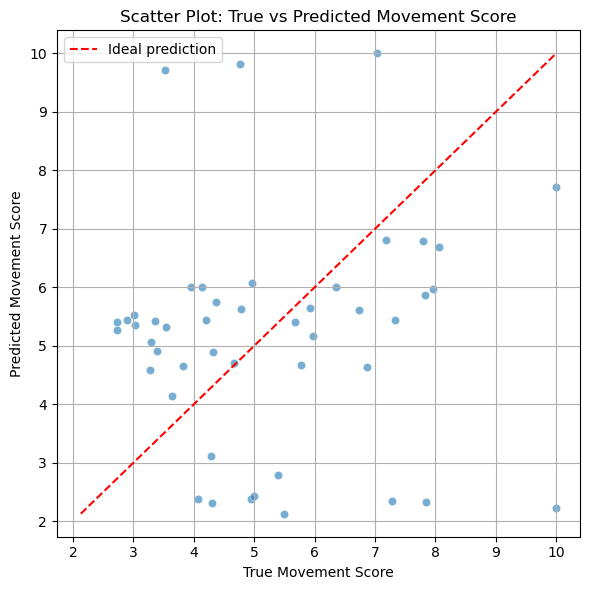

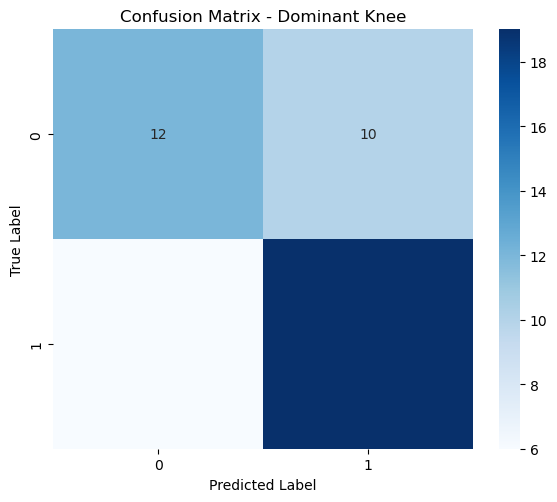

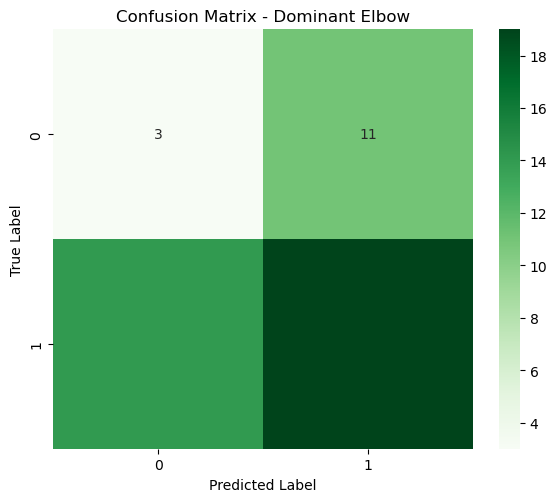

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# הגדרת פרמטרים זהים לקוד האימון המקורי
WINDOW_SIZE = 30
RANDOM_STATE = 42

def load_feature_columns():
    """
    טעינת עמודות המאפיינים ששימשו באימון המודל
    """
    try:
        with open('model_features.txt', 'r') as f:
            feature_columns = f.read().splitlines()
        return feature_columns
    except FileNotFoundError:
        print("שגיאה: קובץ model_features.txt לא נמצא")
        return None

def predict_windows(model, video_window_data, feature_columns, window_size=WINDOW_SIZE):
    """
    ביצוע חיזוי עבור חלון ספציפי בוידאו
    """
    # אם אין מספיק פריימים, נחזיר None
    if len(video_window_data) < window_size:
        return None
    
    # יצירת רצף נתונים
    X = []
    for i in range(0, len(video_window_data) - window_size + 1):
        sequence = video_window_data.iloc[i:i+window_size][feature_columns].values
        X.append(sequence)
    
    X = np.array(X)
    
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X)
    
    # נקח את החיזוי האחרון
    movement_pred = float(y_pred_movement[-1][0])
    knee_pred = int(np.argmax(y_pred_knee_prob[-1]))
    elbow_pred = int(np.argmax(y_pred_elbow_prob[-1]))
    
    return movement_pred, knee_pred, elbow_pred

def predict_test_dataset(model_path='best_mediapipe_infant_movement_model.keras', 
                         dataset_path='test_mediapipe_dataset.csv'):
    """
    ביצוע חיזויים עבור כל חלון בכל וידאו
    """
    # טעינת המודל המאומן
    try:
        import tensorflow.keras as keras
        keras.config.enable_unsafe_deserialization()
        model = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"שגיאה בטעינת המודל: {e}")
        return
    
    # טעינת עמודות המאפיינים
    feature_columns = load_feature_columns()
    if not feature_columns:
        return
    
    # טעינת נתוני הטסט
    try:
        test_data = pd.read_csv(dataset_path)
        
        # המרת עמודות קטגוריאליות למספרים אם נדרש
        for col in ['dominant_knee', 'dominant_elbow']:
            if test_data[col].dtype == 'object':
                le = LabelEncoder()
                test_data[col] = le.fit_transform(test_data[col].astype(str))
    
    except Exception as e:
        print(f"שגיאה בטעינת קובץ הנתונים: {e}")
        return
    
    # אחסון תוצאות
    all_predictions = []
    
    # מעבר על כל הוידאוים והחלונות
    unique_video_windows = test_data.groupby(['video_id', 'window_id'])
    
    for (video_id, window_id), video_window_data in unique_video_windows:
        try:
            # ביצוע חיזוי עבור החלון
            prediction = predict_windows(model, video_window_data, feature_columns)
            
            if prediction is None:
                print(f"לא ניתן לעבד וידאו {video_id}, חלון {window_id}")
                continue
            
            movement_pred, knee_pred, elbow_pred = prediction
            
            # נאסוף מידע על החלון המסוים
            true_movement = video_window_data['overall_movement_score'].iloc[-1]
            true_knee = video_window_data['dominant_knee'].iloc[-1]
            true_elbow = video_window_data['dominant_elbow'].iloc[-1]
            
            # הוספת תוצאות לרשימה
            prediction_result = {
                'video_id': video_id,
                'window_id': window_id,
                'true_movement_score': true_movement,
                'pred_movement_score': movement_pred,
                'true_dominant_knee': true_knee,
                'pred_dominant_knee': knee_pred,
                'true_dominant_elbow': true_elbow,
                'pred_dominant_elbow': elbow_pred
            }
            
            all_predictions.append(prediction_result)
        
        except Exception as e:
            print(f"שגיאה בעיבוד וידאו {video_id}, חלון {window_id}: {e}")
    
    # המרת רשימת התוצאות לDataFrame
    results_df = pd.DataFrame(all_predictions)
    
    # חישוב מדדי ביצועים
    print("\n===== תוצאות החיזוי עבור סט הטסט =====")
    
    # מדדי ביצוע לציון תנועה
    from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
    
    mse_movement = mean_squared_error(results_df['true_movement_score'], results_df['pred_movement_score'])
    rmse_movement = np.sqrt(mse_movement)
    print(f"RMSE for motion score: {rmse_movement:.4f}")
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(results_df['true_dominant_knee'], results_df['pred_dominant_knee'])
    elbow_accuracy = accuracy_score(results_df['true_dominant_elbow'], results_df['pred_dominant_elbow'])
    
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(results_df['true_dominant_knee'], results_df['pred_dominant_knee']))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(results_df['true_dominant_elbow'], results_df['pred_dominant_elbow']))
    
    # שמירת התוצאות לקובץ
    results_df.to_csv('test_mediapipe_predictions.csv', index=False)
    print("\nתוצאות החיזוי נשמרו בקובץ test_mediapipe_predictions.csv")
    # === Additional graphical analysis of the results ===
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Scatter plot: true vs predicted movement score (regression)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x='true_movement_score', y='pred_movement_score', data=results_df, alpha=0.6)

    # Compute min/max for axis and line
    min_val = min(results_df['true_movement_score'].min(), results_df['pred_movement_score'].min())
    max_val = max(results_df['true_movement_score'].max(), results_df['pred_movement_score'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal prediction')

    plt.xlabel("True Movement Score")
    plt.ylabel("Predicted Movement Score")
    plt.title("Scatter Plot: True vs Predicted Movement Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("scatter_movement_score.png")
    plt.show()

    # Confusion matrix – Dominant Knee classification
    cm_knee = confusion_matrix(results_df['true_dominant_knee'], results_df['pred_dominant_knee'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_knee, annot=True, fmt="d", cmap="Blues", square=True,
                xticklabels=np.unique(results_df['true_dominant_knee']),
                yticklabels=np.unique(results_df['true_dominant_knee']))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Dominant Knee")
    plt.tight_layout()
    plt.savefig("confusion_knee.png")
    plt.show()

    # Confusion matrix – Dominant Elbow classification
    cm_elbow = confusion_matrix(results_df['true_dominant_elbow'], results_df['pred_dominant_elbow'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_elbow, annot=True, fmt="d", cmap="Greens", square=True,
                xticklabels=np.unique(results_df['true_dominant_elbow']),
                yticklabels=np.unique(results_df['true_dominant_elbow']))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Dominant Elbow")
    plt.tight_layout()
    plt.savefig("confusion_elbow.png")
    plt.show()
    return results_df

def main():
    # וידוא קיום המודל
    if not os.path.exists('best_mediapipe_infant_movement_model.keras'):
        print("שגיאה: המודל 'best_mediapipe_infant_movement_model.keras' לא נמצא")
        return
    
    # ביצוע חיזויים על סט הטסט
    predict_test_dataset()

if __name__ == "__main__":
    main()